<a href="https://colab.research.google.com/github/thapaliya123/cat_dog_predictions/blob/master/minibatch_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive 
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#import_files_from_gdrive
def import_files_from_gdrive(file_id, file_name):
  # STEP-1: Import Libraries
  !pip install import-ipynb
  import import_ipynb

  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # STEP-2: Autheticate E-Mail IDcom
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # STEP-3: Get File from Drive using file-ID
  #2.1 Get the files
  downloaded = drive.CreateFile({'id':'{}'.format(file_id)}) # replace the id with id of file you want to access
  downloaded.GetContentFile('{}'.format(file_name)) 

In [0]:
#import_files "reg_utils.ipynb" from google drive
import_files_from_gdrive("1U65N9U_E517DZjgtlGQ61SGfVKc8f8Do", "reg_utils.ipynb") #passing file_id, file_name stored in google drive

#reloading imported files to reflect changes in the files
import reg_utils
from importlib import reload  # Py3 only; unneeded in py2.
reg_utils = reload(reg_utils)

importing Jupyter notebook from reg_utils.ipynb


In [0]:
#import files "optimizers.ipynb" from google drive
import_files_from_gdrive("10eDiBVV-x6-j_8pyByqwoACnOGYm7IKg", "optimizers.ipynb") #passing file_id, file_name stored in google drive

#reloading imported files to reflect changes in the files
import optimizers
from importlib import reload
optimizers = reload(optimizers)

importing Jupyter notebook from optimizers.ipynb


In [0]:
#building mini-batch gradient descent deep learning model from scratch
import os
import numpy as np
import pickle
from matplotlib import pyplot as pltcom
import cv2
import keras
from sklearn.model_selection import train_test_split
from reg_utils import *
from optimizers import *

#loading_dataset_and_dividing_into_train_test_sets
FEATURES_PATH_TRAIN = "/content/gdrive/My Drive/colab_notebooks_deeplearning_prac/cats_dogs_predictions/X_train.pickle"
LABELS_PATH_TRAIN = "/content/gdrive/My Drive/colab_notebooks_deeplearning_prac/cats_dogs_predictions/Y_train.pickle"
FEATURES_PATH_TEST = "/content/gdrive/My Drive/colab_notebooks_deeplearning_prac/cats_dogs_predictions/X_test.pickle" 
LABELS_PATH_TEST = "/content/gdrive/My Drive/colab_notebooks_deeplearning_prac/cats_dogs_predictions/Y_test.pickle"
print("loading traning datasets!!!")
X_train, Y_train = load_datasets(FEATURES_PATH_TRAIN, LABELS_PATH_TRAIN)#loading_datasets
print("loaded training datasets...")

print("loading testing datasets!!!")
X_test, Y_test = load_datasets(FEATURES_PATH_TEST, LABELS_PATH_TEST)
print("loaded testing datasets")

print("checking shapes...")
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

loading traning datasets!!!
loaded training datasets...
loading testing datasets!!!
loaded testing datasets
checking shapes...
(49152, 8014)
(49152, 2022)
(1, 8014)
(1, 2022)


In [0]:
import math
#create_batches_from_the_training_sets_before_training_the_model
def random_batches(X, Y, mini_batch_size=64):
  '''
  creates a list of random minibatches from the set (X, Y)

  Arguments:
  X -- input data of shape,(input_size, number_of_examples)
  Y -- true label vector of shape(1, number_of_examples)
  mini_batch_size -- size of the mini-batches integer

  Returns:
  mini_batches -- list of synchronous,(mini_batch_x, mini_batch_y)
  '''
  np.random.seed(1)
  m = X.shape[1]
  mini_batches = []

  # step1-shuffle
  permutation = list(np.random.permutation(m))
  shuffled_X = X[:, permutation]
  shuffled_Y = Y[:, permutation].reshape((1, m))
  # shuffled_X = X
  # shuffled_Y = Y
  #step2-partition shuffled_x, shuffled_Y
  num_complete_mini_batches = math.floor(m/mini_batch_size) #num of minibatches of size mini batch

  for k in range(0 ,num_complete_mini_batches):
    mini_batch_X = shuffled_X[:, (k*mini_batch_size):((k+1)*mini_batch_size)]
    mini_batch_Y = shuffled_Y[:, (k*mini_batch_size):((k+1)*mini_batch_size)]
    
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
  
  if((m%mini_batch_size) != 0):
    mini_batch_X = shuffled_X[:, (num_complete_mini_batches*mini_batch_size):m]
    mini_batch_Y = shuffled_Y[:, (num_complete_mini_batches*mini_batch_size):m]

    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

  return mini_batches


In [0]:
#wrapping_up_nn_process_into_single_functions
def minibatch_gradient_descent_model(X, Y, layers_dims, optimizer, learning_rate=0.001, num_iteration=100, lambd=0, keep_prob=1, mini_batch=32, beta1=0.9, beta2=0.999, epsilon=math.pow(10, -8),print_cost=False):
  '''
  Implements the L-layer neural network
  Arguments:
  X_train -- dataset, numpy array of shape(num_px*num_px*3, 1)
  Y_train -- label sets, numpy array of shape(1, number_of_examples)
  layer_dims -- dimensions of number of layer in the network
  learning_rate -- number of iterations of the optimization loop
  num_iteration -- number of iteration of the optimization loop
  print_cost -- if true, it prints the cost

  return:
  parameters -- parameters learnt by the model.They can the be used to predict 
  '''
  costs = []
  m = X.shape[1]
  t = 0
  parameters = initialize_paramters_deep(layers_dims)
  initial_learning_rate = learning_rate

  if(optimizer == 'gd'):
    #no any initialization is required for  gradient decent optimization process
    pass
  
  elif(optimizer == 'adam'):
    #initializing adam optimizer
    v, s = initialize_adam(parameters)

  for i in range(num_iteration):
    mini_batches = random_batches(X, Y)
    cost_total = 0
    for mini_batch in mini_batches:
      mini_batch_X, mini_batch_Y = mini_batch
          #propagating_forward_in_the_network

      if(keep_prob==1):
        AL, caches = L_model_forward(mini_batch_X, parameters)

      elif(keep_prob<1):
        AL, caches = L_model_forward(mini_batch_X, parameters, keep_prob)

      else:
        pass


      #compute_cost
      if(lambd==0):
        #compute_cost_without_regularization
        cost_total += compute_cost(AL,mini_batch_Y)

      else:
        #compute_cost_without_regularization
        cost_total += compute_cost_with_regularization(AL, mini_batch_Y, parameters, lambd)

      assert(lambd==0 or keep_prob==1)#it is possible to use both regularization and dropout but this project will explore only one at a time
      
      #propagating_backward_in_the_network
      grads = L_model_backward(AL, mini_batch_Y, caches, lambd, keep_prob)

      if(optimizer == 'gd'):
        parameters = update_parameters(parameters, grads, learning_rate)

      elif(optimizer == 'adam'):
        t = t+1 #t_count_for_adam
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
   
    cost_avg = cost_total/m
    if (i%10 == 0) and (print_cost == True):
      print("cost after iteration {} is {}".format(i, cost_avg))
      # learning_rate = initial_learning_rate * (1/(1+(0.01*i)))
    

    costs.append(cost_avg)
  return parameters, costs

In [0]:
# layers_dims = [49152, 64, 32, 16, 1] #  4-layer model
layers_dims = [49152, 32, 16, 1]
parameters, cost = minibatch_gradient_descent_model(X_train, Y_train, layers_dims, optimizer="adam", learning_rate=0.001, num_iteration=250, lambd=0.001, epsilon=math.pow(10, -7), print_cost=True)

cost after iteration 0 is 0.01403569524551162
cost after iteration 10 is 0.010209972667544006
cost after iteration 20 is 0.009501021254406323
cost after iteration 30 is 0.008982501384335413


KeyboardInterrupt: ignored

In [0]:
#import files "metrics.ipynb" from google drive
import_files_from_gdrive("1TFeZIP2rUFyev0Tc0-HTreCAYskMmRCE", "metrics.ipynb") #passing file_id, file_name stored in google drive

#reloading imported files to reflect changes in the files
import metrics
from importlib import reload
metrics = reload(metrics)

plotting_costs


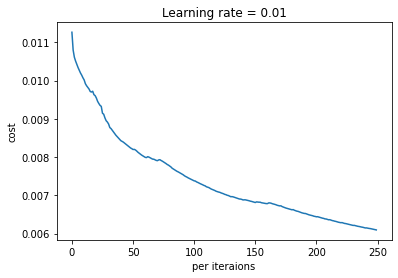

In [0]:
from metrics import *
print("plotting_costs")
plot_cost(cost)

In [0]:

#printing_train_accuracy_of_the_model
predictions = predict((parameters), X_train)
print(predictions.shape)
print(calculate_accuracy(Y_train, predictions, "train"))

(1, 8014)
train_accuracy: 74%


In [0]:
#printing_test_accuracy_of_the_model
predictions_test = predict(parameters, X_test)
print(predictions_test.shape)
print(calculate_accuracy(Y_test, predictions_test, "test"))

(1, 2022)
test_accuracy: 56%


In [0]:

#prediction on new data
import cv2
new_image = cv2.imread("/content/gdrive/My Drive/colab_notebooks_deeplearning_prac/cats_dogs_predictions/datasets/training_set/cats/cat.1.jpg") #read image data from given path
new_image = new_image/255 #normalizing the data
new_image = cv2.resize(new_image, (128, 128)) #resize based on training data
prediction = predict(parameters, new_image) #prediction on resized data 
print(prediction)

In [0]:
r = -4*np.random.rand(5)
print(r)